# Optimizing BART Stations and Pickup Hubs with PageRank
## Using PageRank to rank BART stations and pickup locations based on connectivity and relevance.

In [1]:
!pip install py2neo networkx matplotlib plotly kaleido

     |████████████████████████████████| 79.9 MB 79.6 MB/s eta 0:00:01


In [2]:
import neo4j
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from py2neo import Graph
from IPython.display import display, IFrame

In [3]:
# Connect to Neo4j
driver = neo4j.GraphDatabase.driver(uri="neo4j://neo4j:7687", auth=("neo4j","ucb_mids_w205"))
session = driver.session(database="neo4j")

In [4]:
# Load Dataframes
stations_df = pd.read_csv('data/stations.csv')
travel_times_df = pd.read_csv('data/travel_times.csv')
lines_df = pd.read_csv('data/lines.csv')

## Build the Graph

In [5]:
# Define functions

def my_neo4j_wipe_out_database():
    "wipe out database by deleting all nodes and relationships"
    
    query = "match (node)-[relationship]->() delete node, relationship"
    session.run(query)
    
    query = "match (node) delete node"
    session.run(query)
    
def generate_neo4j_query_from_data(stations_df, travel_times_df):
    # Start the CREATE statement
    query = "CREATE\n"
    
    # Step 1: Add nodes for each station
    station_lines = []
    for _, row in stations_df.iterrows():
        # Use the station name as a Neo4j node identifier and replace spaces with underscores for compatibility
        station_identifier = row['station'].replace(' ', '_')
        
        # Prefix identifier with an underscore if it starts with a digit
        if station_identifier[0].isdigit():
            station_identifier = f"_{station_identifier}"
            
        station_line = (
            f"  ({station_identifier}:Station {{name: '{row['station']}', "
            f"latitude: {row['latitude']}, longitude: {row['longitude']}, "
            f"transfer_time: {row['transfer_time']}}})"
        )
        station_lines.append(station_line)
    
    # Step 2: Add relationships based on travel times
    relationship_lines = []
    for _, row in travel_times_df.iterrows():
        # Use the station names as identifiers, replacing spaces with underscores
        station1 = row['station_1'].replace(' ', '_')
        station2 = row['station_2'].replace(' ', '_')
        
        # Prefix identifiers with an underscore if they start with a digit
        if station1[0].isdigit():
            station1 = f"_{station1}"
        if station2[0].isdigit():
            station2 = f"_{station2}"
        
        relationship_line = (
            f"  ({station1})-[:TRACK {{travel_time: {row['travel_time']}}}]->({station2})"
        )
        relationship_lines.append(relationship_line)
        
        # Assuming undirected track, we add reverse as well
        reverse_relationship_line = (
            f"  ({station2})-[:TRACK {{travel_time: {row['travel_time']}}}]->({station1})"
        )
        relationship_lines.append(reverse_relationship_line)

    # Combine all lines into the final query string
    query += ",\n".join(station_lines + relationship_lines) + "\n"
    
    return query

def my_create_connected_graph():
    """
    Create a connected graph using stations and travel times data.
    Ensures the 'station_graph' projection is dropped if it exists, then creates it with fresh data.
    """

    # Step 1: Drop any existing 'station_graph' projection if it exists
    drop_projection_query = """
    CALL gds.graph.exists('station_graph') YIELD exists
    WHERE exists
    CALL gds.graph.drop('station_graph') YIELD graphName
    RETURN graphName;
    """
    session.run(drop_projection_query)
    print("Checked and dropped any existing 'station_graph' projection if it existed.")

    # Step 2: Wipe out the database
    my_neo4j_wipe_out_database()  # Clears the database completely
    print("Database cleared successfully.")

    # Step 3: Generate and run the CREATE query to add nodes and relationships
    query = generate_neo4j_query_from_data(stations_df, travel_times_df)
    session.run(query)  # Run the query in a Neo4j session to add nodes and relationships
    print("Nodes and relationships created successfully.")

    # Step 4: Create a new 'station_graph' projection for GDS algorithms
    create_projection_query = """
    CALL gds.graph.project(
        'station_graph',
        'Station',
        {
            TRACK: {
                type: 'TRACK',
                orientation: 'UNDIRECTED',
                properties: 'travel_time'
            }
        }
    )
    """
    session.run(create_projection_query)
    print("Graph projection 'station_graph' created successfully.")
    
    # Step 5: Verify that the projection was created successfully
    result = session.run("CALL gds.graph.exists('station_graph') YIELD exists")
    if result.single()['exists']:
        print("Projection 'station_graph' verified to exist.")
    else:
        print("Error: Projection 'station_graph' was not created successfully.")

def my_neo4j_run_query_pandas(query, **kwargs):
    "run a query and return the results in a pandas dataframe"
    
    result = session.run(query, **kwargs)
    df = pd.DataFrame([r.values() for r in result], columns=result.keys())
    
    return df

def my_neo4j_nodes_relationships():
    "print all the nodes and relationships"
   
    print("-------------------------")
    print("  Nodes:")
    print("-------------------------")
    
    query = """
        match (n) 
        return n.name as node_name, labels(n) as labels
        order by n.name
    """
    
    df = my_neo4j_run_query_pandas(query)
    
    number_nodes = df.shape[0]
    
    display(df)
    
    print("-------------------------")
    print("  Relationships:")
    print("-------------------------")
    
    query = """
        match (n1)-[r]->(n2) 
        return n1.name as node_name_1, labels(n1) as node_1_labels, 
            type(r) as relationship_type, n2.name as node_name_2, labels(n2) as node_2_labels
        order by node_name_1, node_name_2
    """
    
    df = my_neo4j_run_query_pandas(query)
    
    number_relationships = df.shape[0]
    
    display(df)
    
    density = (2 * number_relationships) / (number_nodes * (number_nodes - 1))
    
    print("-------------------------")
    print("  Density:", f'{density:.1f}')
    print("-------------------------")

# PageRank query on the 'station_graph'
def run_page_rank():
    """
    Run the PageRank algorithm on the 'station_graph' projection.
    """
    page_rank_query = """
    CALL gds.pageRank.stream('station_graph')
    YIELD nodeId, score
    RETURN gds.util.asNode(nodeId).name AS station, score
    ORDER BY score DESC
    """
    
    page_rank_df = my_neo4j_run_query_pandas(page_rank_query)
    return page_rank_df

In [6]:
# Step 1: Create the graph structure
my_create_connected_graph()

# Parameters for PageRank
max_iterations = 20
damping_factor = 0.05

Checked and dropped any existing 'station_graph' projection if it existed.
Database cleared successfully.
Nodes and relationships created successfully.
Graph projection 'station_graph' created successfully.
Projection 'station_graph' verified to exist.


In [7]:
# Step 4: Run PageRank
pagerank_df = run_page_rank()

In [8]:
# Print all the nodes and relationships
my_neo4j_nodes_relationships()

-------------------------
  Nodes:
-------------------------


,node_name,labels
0,12th Street,[Station]
1,16th Street Mission,[Station]
2,19th Street,[Station]
3,24th Street Mission,[Station]
4,Antioch,[Station]
5,Ashby,[Station]
6,Balboa Park,[Station]
7,Bay Fair,[Station]
8,Berryessa,[Station]
9,Castro Valley,[Station]


-------------------------
  Relationships:
-------------------------


,node_name_1,node_1_labels,relationship_type,node_name_2,node_2_labels
0,12th Street,[Station],TRACK,19th Street,[Station]
1,12th Street,[Station],TRACK,Lake Merritt,[Station]
2,12th Street,[Station],TRACK,West Oakland,[Station]
3,16th Street Mission,[Station],TRACK,24th Street Mission,[Station]
4,16th Street Mission,[Station],TRACK,Civic Center,[Station]
...,...,...,...,...,...
97,West Dublin,[Station],TRACK,Castro Valley,[Station]
98,West Dublin,[Station],TRACK,Dublin,[Station]
99,West Oakland,[Station],TRACK,12th Street,[Station]
100,West Oakland,[Station],TRACK,Embarcadero,[Station]


-------------------------
  Density: 0.1
-------------------------


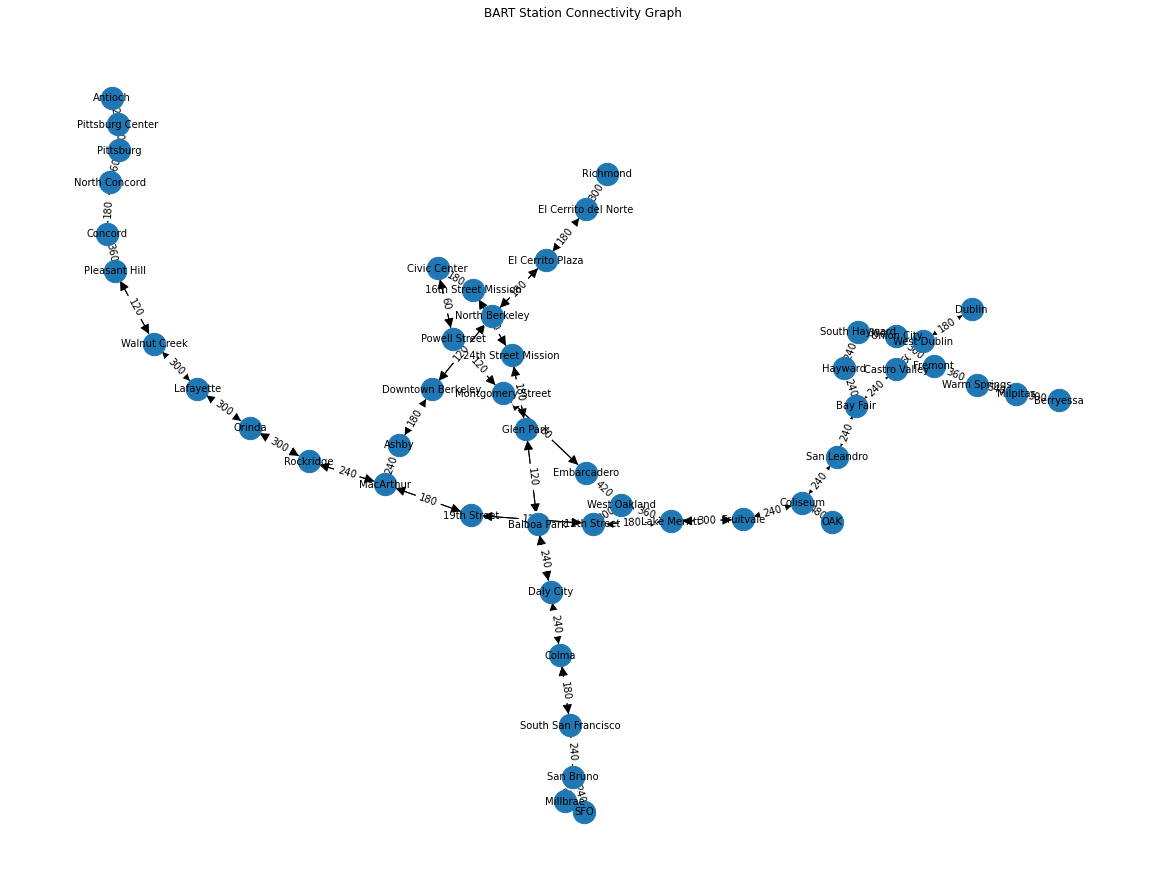

In [9]:
# Query to retrieve nodes and relationships using the correct relationship type
query = """
MATCH (s1:Station)-[r:TRACK]->(s2:Station)
RETURN s1.name AS station_1, s2.name AS station_2, r.travel_time AS travel_time
"""
results = session.run(query).data()

# Check if results are fetched correctly
if results:
    # Create a NetworkX graph
    G = nx.DiGraph()  # Directed graph for routing

    # Add nodes and edges from the Neo4j query results
    for row in results:
        G.add_edge(row['station_1'], row['station_2'], weight=row['travel_time'])

    # Draw the graph
    plt.figure(figsize=(16, 12))
    pos = nx.spring_layout(G, seed=42)  # Position nodes for better visualization
    nx.draw(G, pos, with_labels=True, node_size=500, font_size=10, arrowsize=20)
    nx.draw_networkx_edge_labels(G, pos, edge_labels={(row['station_1'], row['station_2']): row['travel_time'] for row in results})
    plt.title("BART Station Connectivity Graph")
    plt.show()
else:
    print("No data found for the specified relationship type.")

## Draw a Graph

In [10]:
# Step 1: Create a NetworkX graph and add nodes and edges from the Neo4j query results
G = nx.DiGraph()  # Directed graph for routing
for row in results:
    G.add_edge(row['station_1'], row['station_2'], weight=row['travel_time'])

# Step 2: Rank stations by connectivity using degree centrality
degree_centrality = nx.degree_centrality(G)
nx.set_node_attributes(G, degree_centrality, 'degree_centrality')

# Step 3: Identify and mark delivery hubs (top 10% most connected nodes)
hub_threshold = sorted(degree_centrality.values(), reverse=True)[int(len(degree_centrality) * 0.1)]
delivery_hubs = [node for node, centrality in degree_centrality.items() if centrality >= hub_threshold]

# Step 4: Identify multi-route connections (nodes with multiple neighbors)
multi_route_stations = [node for node, degree in G.degree if degree > 1]

# Step 5: Set up Plotly for an interactive visualization
pos = nx.spring_layout(G, seed=42)  # Layout for the node positions

In [11]:
# Create Plotly nodes with color coding for special markers
node_trace = go.Scatter(
    x=[pos[node][0] for node in G.nodes()],
    y=[pos[node][1] for node in G.nodes()],
    mode='markers+text',
    marker=dict(
        size=[20 if node in delivery_hubs else 10 for node in G.nodes()],
        color=['red' if node in delivery_hubs else 'blue' for node in G.nodes()],
        opacity=0.8,
    ),
    text=[f"{node}<br>Centrality: {degree_centrality[node]:.2f}" for node in G.nodes()],
    hoverinfo='text'
)

# Create Plotly edges
edge_trace = go.Scatter(
    x=[],
    y=[],
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines'
)

for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_trace['x'] += (x0, x1, None)
    edge_trace['y'] += (y0, y1, None)

In [12]:
# Set up Plotly layout
layout = go.Layout(
    title='BART Station Connectivity Graph - Optimized for Delivery',
    showlegend=False,
    hovermode='closest',
    margin=dict(b=0, l=0, r=0, t=40),
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
)

# Combine nodes and edges
fig = go.Figure(data=[edge_trace, node_trace], layout=layout)

In [13]:
# Step 6: Save as HTML and PNG
fig.write_html("bart_station_connectivity_graph.html")  # Save as interactive HTML
fig.write_image("bart_station_connectivity_graph.png")  # Save as PNG

# Display the interactive HTML in the notebook
display(IFrame("bart_station_connectivity_graph.html", width=900, height=600))

## Drop Graph

In [14]:
# Step 5: Drop Graph Projection
query_drop_projection = "CALL gds.graph.drop('station_graph');"
my_neo4j_run_query_pandas(query_drop_projection)

# Close the driver after use
driver.close()

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated field from a procedure. ('schema' returned by 'gds.graph.drop' is deprecated.)} {position: line: 1, column: 1, offset: 0} for query: "CALL gds.graph.drop('station_graph');"
